<center><h1>Avhad_Deepa_Project</h1></center>


**Name: Deepa Avhad** <br>
**USC ID: 7023239026**  <br>
**GIT USERNAME: d-avhad** <br>


**References**: <br>

1. https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467

2. https://keras.io/api/data_loading/image/#image_dataset_from_directory-function

3. https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

4. https://medium.com/@nina95dan/simple-image-classification-with-resnet-50-334366e7311a

5. https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

6. https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

Notes:

1. Please note that I have followed my google drive's path location format for DATA path. (i.e. /content/drive/My Drive/Colab Notebooks/Data)
2. Please note that I have removed Image URLs folder from Sport Images folder for data processing purpose(as those were just web URL's of images).
3. For video classification, some files were not readable, so by coding I made .mp4 copies of that. (That code is to be executed once, so I have commented it)


**1. Import Packages**

In [1]:
import glob
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.layers import Flatten



In [22]:
import moviepy.editor as moviepy
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle

**2. Data Exploration and Pre-processing**




Dividing data into train (70%), val(15%) and test(15%) set and applying transformations.

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:


parent_dir = ("/content/drive/My Drive/Colab Notebooks/Data/Sport Images")

# 5 classes
classes = ["baseball", "basketball", "fencing", "tennis", "volleyball"]

# this classes will be decoded as baseball: 0
#                                 basketball:1
#                                 fencing:2
#                                 tennis:3
#                                 volleyball:4

batch_size = 5
target_size = (224, 224)

# performing empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in training set for image augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
  tf.keras.layers.experimental.preprocessing.RandomCrop(height=224, width=224),
])

#whole data
whole_df = tf.keras.utils.image_dataset_from_directory(
    parent_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    batch_size=batch_size,
    image_size=target_size,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
    follow_links=False,
    smart_resize=True,
    
)

print("WHOLE DATA\n",list(whole_df.file_paths))
whole_df=whole_df.map(lambda x, y: (data_augmentation(x), y))


# Create a data set for the train set 
train_df = tf.keras.utils.image_dataset_from_directory(
    parent_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    batch_size=batch_size,
    image_size=target_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    smart_resize=True,
    #list_files=True
    
)
print("classes:",train_df.class_names)
print("TRAINING DATA FILES\n",list(train_df.file_paths))

train_df = train_df.map(lambda x, y: (data_augmentation(x), y))


Found 3279 files belonging to 5 classes.
WHOLE DATA
 ['/content/drive/My Drive/Colab Notebooks/Data/Sport Images/volleyball/00000414.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/volleyball/00000234.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/fencing/00000445.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/baseball/00000074.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/tennis/00000207.JPG', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/baseball/00000282.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/basketball/00000327.png', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/tennis/00000441.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/baseball/00000485.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/fencing/00000653.jpg', '/content/drive/My Drive/Colab Notebooks/Data/Sport Images/baseball/00000581.jpg', '/content/drive/My Drive/Colab No

In [4]:

# validation data 
val_df = tf.keras.utils.image_dataset_from_directory(
    parent_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    batch_size=batch_size,
    image_size=target_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    smart_resize=True
)


Found 3279 files belonging to 5 classes.
Using 983 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_df)
print(val_batches)

tf.Tensor(197, shape=(), dtype=int64)


In [6]:

val_batches = tf.data.experimental.cardinality(val_df).numpy()
test_size = val_batches // 2

test_df = val_df.skip(test_size)


val_df = val_df.take(val_batches - test_size)

print(tf.data.experimental.cardinality(test_df))
print(tf.data.experimental.cardinality(val_df))



tf.Tensor(99, shape=(), dtype=int64)
tf.Tensor(99, shape=(), dtype=int64)


In [7]:
train_x=[]
train_y=[]
count=0

for x,y in train_df:
  train_x.append(x)
  train_y.append(y)
  count=count+1

train_x = tf.concat(train_x, axis=0)
train_y=tf.concat(train_y, axis=0)
print("Training x label length",len(train_x))
print("Training y label length",len(train_y))

Training x label length 2296
Training y label length 2296


In [8]:
test_x=[]
test_y=[]


for x,y in test_df:
  test_x.append(x)
  test_y.append(y)
  

test_x = tf.concat(test_x, axis=0)
test_y=tf.concat(test_y, axis=0)
print("Test x label length",len(test_x))
print("Test y label length",len(test_y))
print("TEST DATA X FEATIRES\n",test_x)
print("TEST DATA Y LABEL\n",test_y)



Test x label length 493
Test y label length 493
TEST DATA X FEATIRES
 tf.Tensor(
[[[[  6.467614    7.135064    2.6026788]
   [  4.989776    5.7129903   3.3513832]
   [  4.5052814   6.5052814   3.5052814]
   ...
   [ 18.482143   27.482143   26.482143 ]
   [ 19.835888   28.835888   27.835888 ]
   [ 24.014614   33.014614   32.014614 ]]

  [[ 11.930923   11.051459    7.2925305]
   [  9.230847    9.692542    7.4616947]
   [  4.8052053   6.0819907   3.443598 ]
   ...
   [ 23.010576   31.648968   31.73379  ]
   [ 25.130772   33.769165   33.853985 ]
   [ 28.72328    37.36167    37.446495 ]]

  [[ 14.747968   13.868504   10.109574 ]
   [ 14.217934   14.217934   12.217934 ]
   [  9.          9.          7.       ]
   ...
   [ 27.205393   35.20539    37.444862 ]
   [ 30.072258   38.072258   40.290188 ]
   [ 33.121803   41.121803   43.65185  ]]

  ...

  [[180.75778   113.75779    96.87833  ]
   [181.62509   114.986694   98.986694 ]
   [180.9867    114.986694   98.986694 ]
   ...
   [243.        1

# **Transfer Learning for Image Classification**

**3. A) Training RESNET50 Model | Graph Plot |Confusion Matrix, Precision, Recall, Accuracy, and F1 score**




In [ ]:

#for RESNET50

dropout_rate = 0.2
num_classes=5

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e.
# we do not change their parameters during training) 

for layer in resnet.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet.output)
x = Flatten(name="flatten")(resnet.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)


res_op = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=resnet.input, outputs=res_op)


model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=2, restore_best_weights=True)


final_resnet=model_resnet.fit(train_df, epochs=100, validation_data=val_df, callbacks=[early_callback],batch_size=5)


Epoch 1/100
460/460 [==============================] - 49s 81ms/step - loss: 1.1448 - accuracy: 0.5819 - val_loss: 0.5474 - val_accuracy: 0.8202
Epoch 2/100
460/460 [==============================] - 36s 78ms/step - loss: 0.8606 - accuracy: 0.6864 - val_loss: 0.5631 - val_accuracy: 0.8404
Epoch 3/100
460/460 [==============================] - 36s 78ms/step - loss: 0.7694 - accuracy: 0.7165 - val_loss: 0.5453 - val_accuracy: 0.8667
Epoch 4/100
460/460 [==============================] - 36s 78ms/step - loss: 0.7522 - accuracy: 0.7374 - val_loss: 0.4921 - val_accuracy: 0.8505
Epoch 5/100
460/460 [==============================] - 36s 78ms/step - loss: 0.7504 - accuracy: 0.7291 - val_loss: 0.4700 - val_accuracy: 0.8667
Epoch 6/100
460/460 [==============================] - 37s 79ms/step - loss: 0.7277 - accuracy: 0.7426 - val_loss: 0.4445 - val_accuracy: 0.8949
Epoch 7/100
460/460 [==============================] - 36s 79ms/step - loss: 0.6856 - accuracy: 0.7557 - val_loss: 0.4164 - val_ac

In [ ]:
tf.keras.models.save_model(model_resnet, 'model_resnet.hdf5')

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

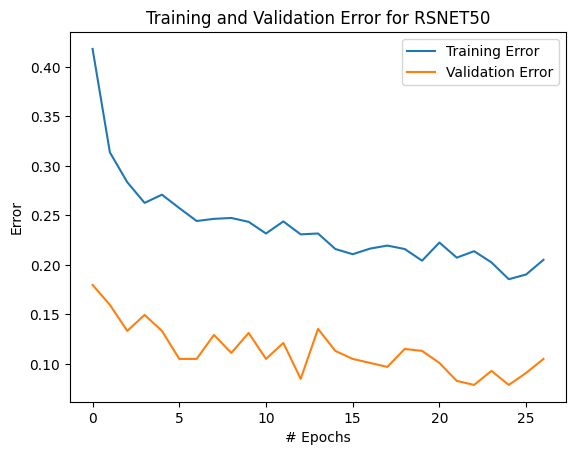

In [ ]:
history=final_resnet
plt.plot([1-x for x in history.history['accuracy']])
plt.plot([1-x for x in history.history['val_accuracy']])
plt.title('Training and Validation Error for RSNET50')
plt.xlabel('# Epochs')
plt.ylabel('Error')
plt.legend(['Training Error', 'Validation Error'])
plt.show()

In [9]:
def print_summary(model,title):
  print("----------------",title,"----------------------\n")
  y_train_pred = model.predict(train_x)
  y_train_pred = np.argmax(y_train_pred, axis=1)

  train_confusion_matrix = confusion_matrix(np.argmax(train_y, axis=1), y_train_pred)
  train_classification_report = classification_report(np.argmax(train_y, axis=1), y_train_pred)

  print("\n------------------------FOR TRAINING-------------------------------------\n")
  print("TRAINING CONFUSION MATRIX : \n",train_confusion_matrix)
  print("\nCLASSIFICATION SUMMARY: TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,F1 SCORE: ")
  print(train_classification_report)
  
  y_test_pred = model.predict(test_x)
  y_test_pred = np.argmax(y_test_pred, axis=1)

  test_confusion_matrix = confusion_matrix(np.argmax(test_y, axis=1), y_test_pred)
  test_classification_report = classification_report(np.argmax(test_y, axis=1), y_test_pred)
  

  print("\n-------------FOR TESTING-------------------------------------")
  print("\nTESTING CONFUSION MATRIX : \n",test_confusion_matrix)
  print("\nCLASSIFICATION SUMMARY: TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,F1 SCORE: ")
  print(test_classification_report)


In [ ]:
print_summary(model_resnet,"RESNET50")




---------------- RESNET50 ----------------------

72/72 [==============================] - 3s 21ms/step

------------------------FOR TRAINING-------------------------------------

TRAINING CONFUSION MATRIX : 
 [[451   9  13  21  17]
 [  7 303   9   4  19]
 [  6   3 405   8  23]
 [ 22  10  11 442  19]
 [ 13  24  16   8 433]]

CLASSIFICATION SUMMARY: TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,F1 SCORE: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       511
           1       0.87      0.89      0.88       342
           2       0.89      0.91      0.90       445
           3       0.92      0.88      0.90       504
           4       0.85      0.88      0.86       494

    accuracy                           0.89      2296
   macro avg       0.89      0.89      0.89      2296
weighted avg       0.89      0.89      0.89      2296

16/16 [==============================] - 1s 33ms/step

-------------FOR TESTING--------------------------

**3 B) Training EFFICIENTB0 Model | Graph Plot |Confusion Matrix, Precision, Recall, Accuracy, and F1 score**

In [10]:
# EfficientNetB0

input_shape=(224, 224,3)
num_classes=5

eff_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in eff_net.layers:
    layer.trainable = False

top_model = GlobalAveragePooling2D()(eff_net.output)

top_model = Flatten(name="flatten")(top_model)

top_model = Dense(128, activation='relu')(top_model)

top_model=BatchNormalization()(top_model)

top_model = Dropout(0.2)(top_model)

output_layer = Dense(num_classes, activation='softmax')(top_model)

eff_net_model = Model(inputs=eff_net.input, outputs=output_layer)

eff_net_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=2, restore_best_weights=True)

eff_net_history=eff_net_model.fit(train_df, epochs=100, validation_data=val_df, callbacks=[early_callback],batch_size=5)



Epoch 1/100
460/460 [==============================] - 44s 78ms/step - loss: 0.8547 - accuracy: 0.6860 - val_loss: 0.2357 - val_accuracy: 0.9152
Epoch 2/100
460/460 [==============================] - 34s 74ms/step - loss: 0.6240 - accuracy: 0.7818 - val_loss: 0.2248 - val_accuracy: 0.9253
Epoch 3/100
460/460 [==============================] - 34s 73ms/step - loss: 0.5887 - accuracy: 0.7953 - val_loss: 0.1757 - val_accuracy: 0.9434
Epoch 4/100
460/460 [==============================] - 34s 74ms/step - loss: 0.5456 - accuracy: 0.8145 - val_loss: 0.1683 - val_accuracy: 0.9515
Epoch 5/100
460/460 [==============================] - 34s 73ms/step - loss: 0.5524 - accuracy: 0.8036 - val_loss: 0.1435 - val_accuracy: 0.9556
Epoch 6/100
460/460 [==============================] - 34s 73ms/step - loss: 0.5091 - accuracy: 0.8223 - val_loss: 0.1546 - val_accuracy: 0.9475
Epoch 7/100
460/460 [==============================] - 34s 74ms/step - loss: 0.4820 - accuracy: 0.8341 - val_loss: 0.1804 - val_ac

In [11]:
#tf.keras.models.save_model(eff_net_model, 'model_effnet.hdf5')
eff_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [12]:
def plot_function(history_model,title):
  history=history_model
  plt.plot([1-x for x in history.history['accuracy']])
  plt.plot([1-x for x in history.history['val_accuracy']])
  plt.title('Training and Validation Error for'+ title)
  plt.xlabel('# Epochs')
  plt.ylabel('Error')
  plt.legend(['Training Error', 'Validation Error'])
  plt.show()

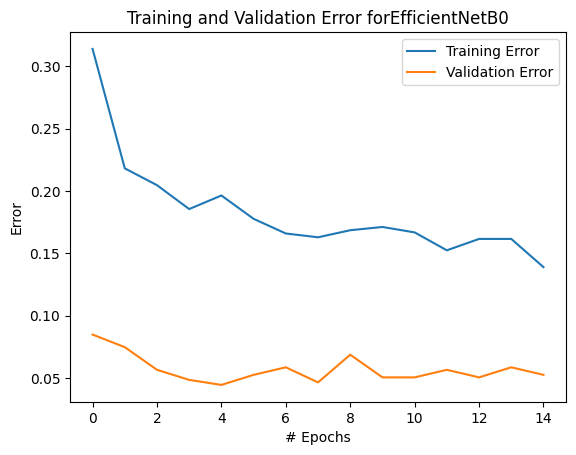

In [13]:
plot_function(eff_net_history,"EfficientNetB0")

In [14]:
print_summary(eff_net_model,"EfficientNetB0")

---------------- EfficientNetB0 ----------------------

72/72 [==============================] - 4s 28ms/step

------------------------FOR TRAINING-------------------------------------

TRAINING CONFUSION MATRIX : 
 [[470   3  25   5   8]
 [  1 315   5   4  17]
 [  5   4 421   3  12]
 [ 28   3   9 453  11]
 [  7  12   9  12 454]]

CLASSIFICATION SUMMARY: TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,F1 SCORE: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       511
           1       0.93      0.92      0.93       342
           2       0.90      0.95      0.92       445
           3       0.95      0.90      0.92       504
           4       0.90      0.92      0.91       494

    accuracy                           0.92      2296
   macro avg       0.92      0.92      0.92      2296
weighted avg       0.92      0.92      0.92      2296

16/16 [==============================] - 1s 42ms/step

-------------FOR TESTING--------------------

**3 C)  Training VGG16 Model | Graph Plot |Confusion Matrix, Precision, Recall, Accuracy, and F1 score**

In [18]:
# for VGG16

input_shape=(224, 224,3)
num_classes=5

vg = VGG16(include_top=False,weights='imagenet', input_shape=input_shape)

for layer in vg.layers:
    layer.trainable = False

top_model = GlobalAveragePooling2D()(vg.output)

top_model = Flatten(name="flatten")(top_model)

top_model = Dense(200, activation='relu')(top_model)
top_model = Dense(100, activation='relu')(top_model)
top_model = Dense(50, activation='relu')(top_model)

top_model=BatchNormalization()(top_model)

top_model = Dropout(0.2)(top_model)

output_layer = Dense(num_classes, activation='softmax')(top_model)

vgg_model = Model(inputs=vg.input, outputs=output_layer)

vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=2, restore_best_weights=True)


vgg_history=vgg_model.fit(train_df, epochs=100, validation_data=val_df, callbacks=[early_callback],batch_size=5)


Epoch 1/100
460/460 [==============================] - 38s 79ms/step - loss: 1.2886 - accuracy: 0.4926 - val_loss: 2.9704 - val_accuracy: 0.2505
Epoch 2/100
460/460 [==============================] - 36s 78ms/step - loss: 1.1127 - accuracy: 0.5788 - val_loss: 0.8186 - val_accuracy: 0.6889
Epoch 3/100
460/460 [==============================] - 36s 78ms/step - loss: 0.9602 - accuracy: 0.6572 - val_loss: 0.7795 - val_accuracy: 0.7475
Epoch 4/100
460/460 [==============================] - 36s 78ms/step - loss: 0.9096 - accuracy: 0.6699 - val_loss: 0.6391 - val_accuracy: 0.7798
Epoch 5/100
460/460 [==============================] - 36s 77ms/step - loss: 0.8384 - accuracy: 0.7051 - val_loss: 1.4838 - val_accuracy: 0.6121
Epoch 6/100
460/460 [==============================] - 36s 77ms/step - loss: 0.8628 - accuracy: 0.6903 - val_loss: 0.5005 - val_accuracy: 0.8323
Epoch 7/100
460/460 [==============================] - 36s 78ms/step - loss: 0.8191 - accuracy: 0.7112 - val_loss: 0.4428 - val_ac

In [19]:
tf.keras.models.save_model(vgg_model, 'model_vgg.hdf5')

In [20]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

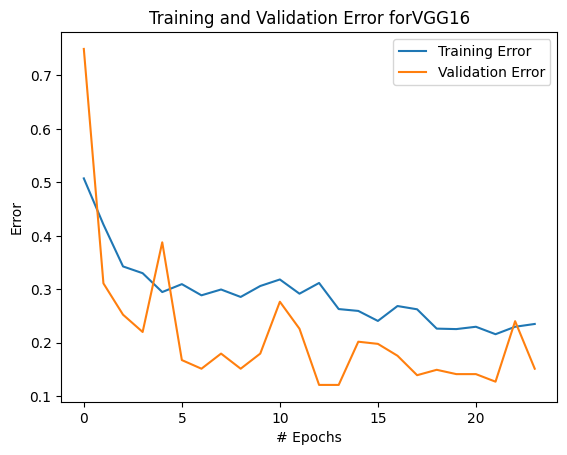

In [21]:
plot_function(vgg_history,"VGG16")

In [22]:
print_summary(vgg_model,"VGG16")

---------------- VGG16 ----------------------

72/72 [==============================] - 3s 39ms/step

------------------------FOR TRAINING-------------------------------------

TRAINING CONFUSION MATRIX : 
 [[438  12  24  20  17]
 [ 10 294  10   4  24]
 [ 15  12 400   4  14]
 [ 59  13  31 381  20]
 [ 13  24  27   6 424]]

CLASSIFICATION SUMMARY: TRAIN ACCURACY,TRAIN PRECISION,TRAIN RECALL,F1 SCORE: 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       511
           1       0.83      0.86      0.84       342
           2       0.81      0.90      0.85       445
           3       0.92      0.76      0.83       504
           4       0.85      0.86      0.85       494

    accuracy                           0.84      2296
   macro avg       0.85      0.85      0.84      2296
weighted avg       0.85      0.84      0.84      2296

16/16 [==============================] - 1s 38ms/step

-------------FOR TESTING-----------------------------

In [23]:

with open('initial_vgg.pkl', 'wb') as file:
    pickle.dump(vgg_model, file)

In [25]:
with open('initial_vgg.pkl', 'rb') as file:
    mv = pickle.load(file)
#print(mv)

So from above details,conclusion for Image classification for three models:

Model     &ensp;    Train Accuracy      &ensp;          Test Accuracy <br>
VGG16      &emsp;        0.84          &emsp;&emsp;               0.86 <br>
EfficientNetB0     &ensp;   0.92         &emsp;                      0.96<br>
Resnet50      &emsp;        0.89           &emsp;                 0.88 <br>

***For our dataset we can see that, EfficientNetB0 has better accuracy than rest models for image classification using transfer learning.***


# **4. Video Classification Using Moving Averages**




**i.  Reusing the validation and test data and training  the networks-RESNET50,EFFICIENTNETB0,VGG16 & using early stoping to avoid overfitting**

In [ ]:
# A. RESNET 50
#retraining the model : Since we have trained model already on trained data, 
# SO now training it on validation data set and taking test dataset as validation.

video_resnet_model = tf.keras.models.load_model('model_resnet.hdf5')

callback_function_resnet = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=2, restore_best_weights=True)

video_resnet_history=video_resnet_model.fit(val_df, epochs=100, validation_data=test_df, callbacks=[callback_function_resnet],batch_size=5)



Epoch 1/100
99/99 [==============================] - 6s 36ms/step - loss: 0.4656 - accuracy: 0.8444 - val_loss: 0.2865 - val_accuracy: 0.8905
Epoch 2/100
99/99 [==============================] - 2s 22ms/step - loss: 0.3011 - accuracy: 0.9071 - val_loss: 0.2535 - val_accuracy: 0.9067
Epoch 3/100
99/99 [==============================] - 2s 22ms/step - loss: 0.1960 - accuracy: 0.9495 - val_loss: 0.2324 - val_accuracy: 0.9168
Epoch 4/100
99/99 [==============================] - 2s 21ms/step - loss: 0.1444 - accuracy: 0.9576 - val_loss: 0.2364 - val_accuracy: 0.9189
Epoch 5/100
99/99 [==============================] - 2s 21ms/step - loss: 0.1150 - accuracy: 0.9778 - val_loss: 0.2420 - val_accuracy: 0.9148
Epoch 6/100
99/99 [==============================] - 2s 20ms/step - loss: 0.1223 - accuracy: 0.9697 - val_loss: 0.2394 - val_accuracy: 0.9168
Epoch 7/100
99/99 [==============================] - 2s 20ms/step - loss: 0.1254 - accuracy: 0.9677 - val_loss: 0.2395 - val_accuracy: 0.9189
Epoch 

In [17]:
#EFFNET

#retraining the model : Since we have trained model already on trained data, 
# SO now training it on validation data set and taking test dataset as validation.

# according to tensorflow documentation fit() model retrains, without resseting previous settings.

early_callback_eff_net = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=2, restore_best_weights=True)

video_eff_net_history=eff_net_model.fit(val_df, epochs=100, validation_data=test_df, callbacks=[early_callback_eff_net],batch_size=5)

Epoch 1/100
99/99 [==============================] - 3s 25ms/step - loss: 0.1352 - accuracy: 0.9556 - val_loss: 0.1247 - val_accuracy: 0.9493
Epoch 2/100
99/99 [==============================] - 3s 27ms/step - loss: 0.1446 - accuracy: 0.9475 - val_loss: 0.1183 - val_accuracy: 0.9574
Epoch 3/100
99/99 [==============================] - 2s 23ms/step - loss: 0.1632 - accuracy: 0.9475 - val_loss: 0.1441 - val_accuracy: 0.9533
Epoch 4/100
99/99 [==============================] - 2s 24ms/step - loss: 0.1176 - accuracy: 0.9556 - val_loss: 0.1465 - val_accuracy: 0.9513
Epoch 5/100
99/99 [==============================] - 2s 23ms/step - loss: 0.1387 - accuracy: 0.9556 - val_loss: 0.1278 - val_accuracy: 0.9533
Epoch 6/100
99/99 [==============================] - 2s 23ms/step - loss: 0.0789 - accuracy: 0.9818 - val_loss: 0.1374 - val_accuracy: 0.9473
Epoch 7/100
99/99 [==============================] - 2s 24ms/step - loss: 0.0534 - accuracy: 0.9879 - val_loss: 0.1192 - val_accuracy: 0.9635
Epoch 

In [26]:
#VGG16
video_vgg_model = tf.keras.models.load_model('model_vgg.hdf5')
early_callback_vgg = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=2, restore_best_weights=True)

video_vgg_history=video_vgg_model.fit(val_df, epochs=100, validation_data=test_df, callbacks=[early_callback_vgg],batch_size=5)
tf.keras.models.save_model(video_vgg_model, 'latest_vgg.hdf5')

Epoch 1/100
99/99 [==============================] - 5s 33ms/step - loss: 0.7487 - accuracy: 0.7455 - val_loss: 0.4546 - val_accuracy: 0.8621
Epoch 2/100
99/99 [==============================] - 3s 26ms/step - loss: 0.5195 - accuracy: 0.8384 - val_loss: 0.8932 - val_accuracy: 0.6694
Epoch 3/100
99/99 [==============================] - 3s 26ms/step - loss: 0.5956 - accuracy: 0.8081 - val_loss: 0.5721 - val_accuracy: 0.8093
Epoch 4/100
99/99 [==============================] - 3s 26ms/step - loss: 0.4817 - accuracy: 0.8525 - val_loss: 0.3838 - val_accuracy: 0.8763
Epoch 5/100
99/99 [==============================] - 3s 26ms/step - loss: 0.3481 - accuracy: 0.8990 - val_loss: 0.6997 - val_accuracy: 0.8174
Epoch 6/100
99/99 [==============================] - 3s 26ms/step - loss: 0.3504 - accuracy: 0.9030 - val_loss: 0.4576 - val_accuracy: 0.8479
Epoch 7/100
99/99 [==============================] - 3s 27ms/step - loss: 0.3152 - accuracy: 0.8970 - val_loss: 0.3283 - val_accuracy: 0.8824
Epoch 

In [27]:
with open('later_vgg.pkl', 'wb') as file:
    pickle.dump(video_vgg_model, file)

**(ii) and (iii)**

Doing video classification as mentioned in part f ii and f iii.  Here I am using all frames of video. i.e. equal space of 1 interval for L=# frames per video. Also for moving average I have used panda library's rolling function.

In [18]:

def video_classification(model):

  L = 100  # Default number of frames
  num_classes=5

  video_path = ("/content/drive/My Drive/Colab Notebooks/Data/Sport Videos")
  img_classes = ["baseball", "basketball", "fencing", "tennis", "volleyball"]  
                # 0,          1,              2,        3,          4
  video_classes=["BaseballPitch", "Basketball", "Fencing", "TennisSwing", "VolleyballSpiking"]  

  video_dict={}  #storing video name and true label
  predicted_dict={}
  num=0
  skip=0
  counter=0
  res_labe1=2
  for file_name in os.listdir(video_path):
      print("---------------------for ",file_name,"------------------------------")
      num=0
      for i in os.listdir(video_path+'/'+file_name):
          

          num=num+1
          video_name=i

          if (file_name=="BaseballPitch" ):
            video_dict[i]=0
            res_val=0
          elif (file_name=="Basketball" ):
            video_dict[i]=1
            res_val=1
          elif (file_name=="Fencing" ):
            video_dict[i]=2
            res_val=2
          elif (file_name=="TennisSwing" ):
            video_dict[i]=3
            res_val=3
          elif (file_name=="VolleyballSpiking" ):
            video_dict[i]=4
            res_val=4

          if '.mp4'  not in video_name:

            video_cap = cv2.VideoCapture(video_path+'/'+file_name+'/'+video_name)
            
            vid_total_frame =int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

            #please note that I have used all frames of each video (i.e  equally spaced of interval 1)
            L=vid_total_frame
            
            prob_res_vectors = np.zeros((L, num_classes))

            # Set the frame index to 0
            frame_idx = 0

            while (frame_idx<L):

                ret, frame = video_cap.read()

              
                if not ret:
                    break
                    '''
                    # Note following commented code is for dealing with 12 files which are not read by opencv.
                    # Converting those file in mp4 and saving in Folder.
                    # Run the following code only once.
                    #Also note that, later on running multiple times, opencv started reading those 12 avi files.

                    print(video_name)
                    copy=video_name[:-4]+".mp4"
                    print("TAKING MP4")
                    my_file = Path(video_path+"/"+file_name+"/"+copy)

                    if not my_file.is_file():
                      clip = moviepy.VideoFileClip(video_path+"/"+file_name+"/"+video_name)
                      clip.write_videofile(video_path+"/"+file_name+"/"+copy)
                    video_cap.release()
                    video_cap = cv2.VideoCapture(video_path+"/"+file_name+"/"+copy)
                    ret, frame = video_cap.read()

                    if not ret:
                      print("file still not readable")
                      break
                    '''
                frame = cv2.resize(frame, (224, 224))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = np.expand_dims(frame, axis=0)

                res = model.predict(frame,verbose=0)

                #print("Model Prediction",res)
                prob_res_vectors[frame_idx] = res

                frame_idx += 1
              
            video_cap.release()

            # calculating moving average for L frames

            trans_res=np.transpose(prob_res_vectors)
            rolling_avg=[]
            cl=[]
            for row in range(0,len(trans_res)):
              #print(row)
              rolling_avg.append(pd.Series(trans_res[row]).rolling(window=5).mean())
            
            cl.append(rolling_avg[0][np.argmax(rolling_avg[0],axis=0)])
            cl.append(rolling_avg[1][np.argmax(rolling_avg[1],axis=0)])
            cl.append(rolling_avg[2][np.argmax(rolling_avg[2],axis=0)])
            cl.append(rolling_avg[3][np.argmax(rolling_avg[3],axis=0)])
            cl.append(rolling_avg[4][np.argmax(rolling_avg[4],axis=0)])
            
            res_label= np.argmax(cl,axis=0) 

            predicted_dict[video_name]=res_label

           
            if(num<=5):
              print("True label of ",video_name," is : ",video_dict[video_name])
              print("Predicted label of ",video_name," is :",res_label)
            
            
            # end of inner for loop

  return video_dict,  predicted_dict
      

**PREDICTIONS FOR RESNET50**

In [ ]:
#for resnet
print("PRINITING FIRST FEW PREDICTION OF EACH CLASS")
true_y_resnet, predict_y_resnet =video_classification(video_resnet_model)

PRINITING FIRST FEW PREDICTION OF EACH CLASS
---------------------for  Fencing ------------------------------
True label of  v_Fencing_g11_c02.avi  is :  2
Predicted label of  v_Fencing_g11_c02.avi  is : 2
True label of  v_Fencing_g07_c03.avi  is :  2
Predicted label of  v_Fencing_g07_c03.avi  is : 2
True label of  v_Fencing_g13_c03.avi  is :  2
Predicted label of  v_Fencing_g13_c03.avi  is : 4
True label of  v_Fencing_g11_c04.avi  is :  2
Predicted label of  v_Fencing_g11_c04.avi  is : 2
True label of  v_Fencing_g13_c04.avi  is :  2
Predicted label of  v_Fencing_g13_c04.avi  is : 2
---------------------for  TennisSwing ------------------------------
True label of  v_TennisSwing_g11_c02.avi  is :  3
Predicted label of  v_TennisSwing_g11_c02.avi  is : 3
True label of  v_TennisSwing_g01_c01.avi  is :  3
Predicted label of  v_TennisSwing_g01_c01.avi  is : 3
True label of  v_TennisSwing_g01_c03.avi  is :  3
Predicted label of  v_TennisSwing_g01_c03.avi  is : 3
True label of  v_TennisSwing_

**PREDICTIONS FOR EFFNETB0** 

In [19]:
#effent

print("PRINITING FIRST FEW PREDICTION OF EACH CLASS")
true_y_effnet, predict_y_effnet= video_classification(eff_net_model)

PRINITING FIRST FEW PREDICTION OF EACH CLASS
---------------------for  Fencing ------------------------------
True label of  v_Fencing_g11_c02.avi  is :  2
Predicted label of  v_Fencing_g11_c02.avi  is : 2
True label of  v_Fencing_g07_c03.avi  is :  2
Predicted label of  v_Fencing_g07_c03.avi  is : 2
True label of  v_Fencing_g13_c03.avi  is :  2
Predicted label of  v_Fencing_g13_c03.avi  is : 2
True label of  v_Fencing_g11_c04.avi  is :  2
Predicted label of  v_Fencing_g11_c04.avi  is : 2
True label of  v_Fencing_g13_c04.avi  is :  2
Predicted label of  v_Fencing_g13_c04.avi  is : 2
---------------------for  TennisSwing ------------------------------
True label of  v_TennisSwing_g11_c02.avi  is :  3
Predicted label of  v_TennisSwing_g11_c02.avi  is : 3
True label of  v_TennisSwing_g01_c01.avi  is :  3
Predicted label of  v_TennisSwing_g01_c01.avi  is : 3
True label of  v_TennisSwing_g01_c03.avi  is :  3
Predicted label of  v_TennisSwing_g01_c03.avi  is : 3
True label of  v_TennisSwing_

**PREDICTIONS FOR VGG16**

In [29]:
#vgg

video_vgg_model1 = tf.keras.models.load_model('latest_vgg.hdf5')
print("PRINITING FIRST FIVE PREDICTION OF EACH CLASS")  
true_y_vgg, predict_y_vgg = video_classification(video_vgg_model1) 

PRINITING FIRST FIVE PREDICTION OF EACH CLASS
---------------------for  Fencing ------------------------------
True label of  v_Fencing_g11_c02.avi  is :  2
Predicted label of  v_Fencing_g11_c02.avi  is : 2
True label of  v_Fencing_g07_c03.avi  is :  2
Predicted label of  v_Fencing_g07_c03.avi  is : 3
True label of  v_Fencing_g13_c03.avi  is :  2
Predicted label of  v_Fencing_g13_c03.avi  is : 2
True label of  v_Fencing_g11_c04.avi  is :  2
Predicted label of  v_Fencing_g11_c04.avi  is : 2
True label of  v_Fencing_g13_c04.avi  is :  2
Predicted label of  v_Fencing_g13_c04.avi  is : 2
---------------------for  TennisSwing ------------------------------
True label of  v_TennisSwing_g11_c02.avi  is :  3
Predicted label of  v_TennisSwing_g11_c02.avi  is : 3
True label of  v_TennisSwing_g01_c01.avi  is :  3
Predicted label of  v_TennisSwing_g01_c01.avi  is : 3
True label of  v_TennisSwing_g01_c03.avi  is :  3
Predicted label of  v_TennisSwing_g01_c03.avi  is : 3
True label of  v_TennisSwing

**(iv)  Confusion Matrix, Precision, Recall, Accuracy, and F1 score  for all 3 models**

In [20]:
def display_summary(pred_y, title):

  true_y=[]

  #getting true labels from key names of video file
  labels= {"BaseballPitch":0, "Basketball":1, "Fencing":2, "TennisSwing":3, "VolleyballSpiking":4}

  for key,val in pred_y.items():
    f_split=key.split('_')
    lab=labels.get(f_split[1])
    true_y.append(lab)


  pred_y=list(pred_y.values())

  cm = confusion_matrix(true_y, pred_y)
  test_classification_report = classification_report(true_y, pred_y)

  
  print("--------------------FOR",title,"MODEL-----------------")
  print("\nCONFUSION MATRIX:\n")
  print(cm)
  print("\nPRECISION, RECALL, ACCURACY, and F1-SCORE\n")
  print(test_classification_report)
  


In [ ]:
#for resnet

display_summary(predict_y_resnet,"RESNET50")

--------------------FOR RESNET50 MODEL-----------------

CONFUSION MATRIX:

[[ 55   0  48  42   5]
 [  0   0  74  33  30]
 [  0   0 105   0   6]
 [  0   0  17 129  21]
 [  0   0  74   1  41]]

PRECISION, RECALL, ACCURACY, and F1-SCORE

              precision    recall  f1-score   support

           0       1.00      0.37      0.54       150
           1       0.00      0.00      0.00       137
           2       0.33      0.95      0.49       111
           3       0.63      0.77      0.69       167
           4       0.40      0.35      0.37       116

    accuracy                           0.48       681
   macro avg       0.47      0.49      0.42       681
weighted avg       0.50      0.48      0.43       681



In [21]:



#for effnet
display_summary(predict_y_effnet,"EfficientNetB0")


--------------------FOR EfficientNetB0 MODEL-----------------

CONFUSION MATRIX:

[[137   0   6   7   0]
 [  0   0 109   8  20]
 [  0   0 111   0   0]
 [  3   0  26 138   0]
 [  0   0  72   0  44]]

PRECISION, RECALL, ACCURACY, and F1-SCORE

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       150
           1       0.00      0.00      0.00       137
           2       0.34      1.00      0.51       111
           3       0.90      0.83      0.86       167
           4       0.69      0.38      0.49       116

    accuracy                           0.63       681
   macro avg       0.58      0.62      0.56       681
weighted avg       0.61      0.63      0.59       681



In [31]:
display_summary(predict_y_vgg,"VGG16")

--------------------FOR VGG16 MODEL-----------------

CONFUSION MATRIX:

[[106   0  25  19   0]
 [  5   0  63  68   1]
 [  0   0 103   8   0]
 [  0   0   6 161   0]
 [  0   0  90  12  14]]

PRECISION, RECALL, ACCURACY, and F1-SCORE

              precision    recall  f1-score   support

           0       0.95      0.71      0.81       150
           1       0.00      0.00      0.00       137
           2       0.36      0.93      0.52       111
           3       0.60      0.96      0.74       167
           4       0.93      0.12      0.21       116

    accuracy                           0.56       681
   macro avg       0.57      0.54      0.46       681
weighted avg       0.58      0.56      0.48       681



**Conclusion for Video Classification: Accuracy for 3 models:**
1. Resnet50 : 48%
2. EFFICIENT NETB0 : 63%
3. VGG16 : 56% 

***We can see that EFFICIENT NET B0 model has better accuracy than the rest for our given dataset.***<br> 
***Even for image classification it had better accuracy.*** <br>
***So we can say that for this dataset efficientnetB0 is slightly better than the rest models. Vgg16 comes on second position and then resnet50. ***